In [ ]:
#Run this cell to download all the required files
%%capture
#Downloading dataset
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CbIhiZbAa-Ve0Z5Sef0YskCLKF7vJycu' -O Case_Study_Data_Train.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1ib_Us0Q90ltO-AwewsxnLpUt_nVIWUII' -O Case_Study_Data_Test.csv

# Installing and updating required libraries
!pip install -U pandas_profiling
!pip install -U imblearn
!pip install 'pandas-profiling[notebook,html]'
!pip install xgboost
!pip install lightgbm
!pip install spacy

!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_md-0.4.0.tar.gz

#Standard libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas_profiling import ProfileReport
import pandas_profiling
from sklearn.preprocessing import LabelEncoder
import string
import re
from sklearn.pipeline import Pipeline
import gc

#Feature selection and extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor , XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier


# Models evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE

#NLP libraries
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download("popular")

import spacy
nlp = spacy.load("en_core_sci_md")
#over_sampling
from imblearn.over_sampling import BorderlineSMOTE

import warnings
warnings.filterwarnings('ignore')

In [ ]:
med_df_train = pd.read_csv('Case_Study_Data_Train.csv')
med_df_test = pd.read_csv('Case_Study_Data_Test.csv')

In [ ]:
profile = ProfileReport(med_df_train, html = {'style': {'full_width': True}}, missing_diagrams=None, duplicates=None, interactions=None, sample=None,)
profile

Summarize dataset:   0%|          | 0/16 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

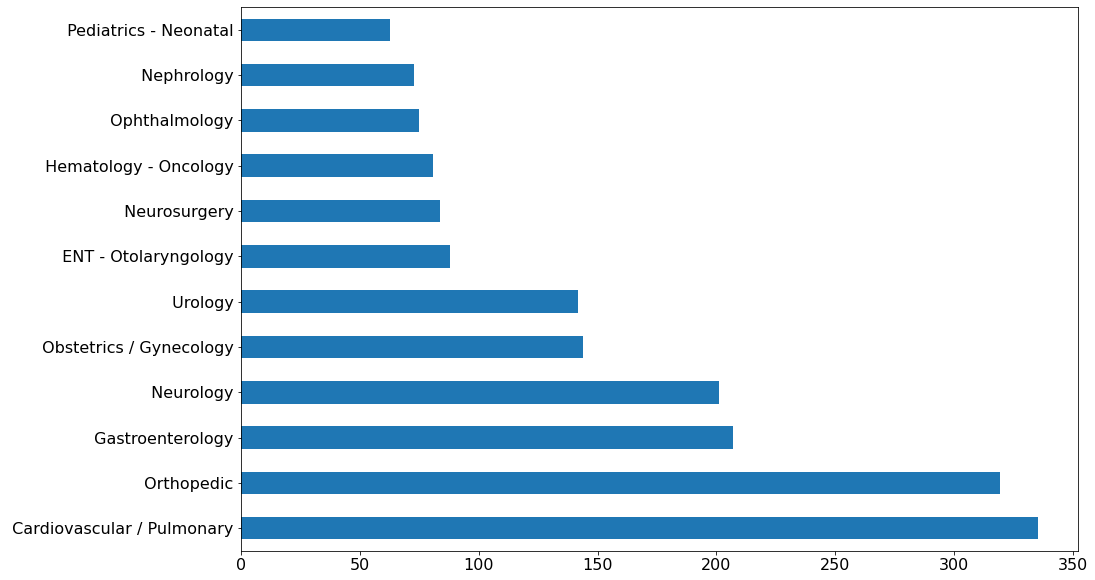

In [ ]:
med_df_train['Package'].value_counts().plot(kind='barh', figsize=(15,10), fontsize=16)

**Classes are imbalanced we can balanced it via oversampling**

In [ ]:
from spacy import displacy
samplee = med_df_train['Medical_Description'].iloc[0]
samplee

'TITLE OF OPERATION: , Placement of right new ventriculoperitoneal (VP) shunts Strata valve and to removal of right frontal Ommaya reservoir.,INDICATION FOR SURGERY: , The patient is a 2-month-old infant, born premature with intraventricular hemorrhage and Ommaya reservoir recommendation for removal and replacement with a new VP shunt.,PREOP DIAGNOSIS: , Hydrocephalus.,POSTOP DIAGNOSIS: , Hydrocephalus.,PROCEDURE DETAIL: , The patient was brought to the operating room, underwent induction of general endotracheal airway, positioned supine, head turned towards left.  The right side prepped and draped in the usual sterile fashion.  Next, using a 15 blade scalpel, two incisions were made, one in the parietooccipital region and.  The second just lateral to the umbilicus.  Once this was clear, the Bactiseal catheter was then tunneled.  This was connected to a Strata valve.  The Strata valve was programmed to a setting of 1.01 and this was ensured.  The small burr hole was then created.  The 

In [ ]:
# visualizing the dependency tree for the first sentenece in our sample Medical_Description
doc = nlp('Placement of right new ventriculoperitoneal (VP) shunts Strata valve and to removal of right frontal Ommaya reservoir.,INDICATION FOR SURGERY')
displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

In [ ]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count

sent_count,word_count= get_sentence_word_count(med_df_train['Medical_Description'].tolist())
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))

Number of sentences in transcriptions column: 49418
Number of unique words in transcriptions column: 28742


# Approach_1:  
**clean_text >> lemmatize_text >> TfidfVectorizer >> PCA >> Model traing & testing**

In [ ]:
train_data = med_df_train[['Medical_Description', 'Package']]
train_data = train_data.drop(train_data[train_data['Medical_Description'].isna()].index)

test_data = med_df_test[['Medical_Description', 'Package']]
test_data = test_data.drop(test_data[test_data['Medical_Description'].isna()].index)

def clean_text(text): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2) # replace REPLACE_BY_SPACE_RE symbols by space in text
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))       
    return ' '.join(wordlist)

In [ ]:
train_data['Medical_Description'] = train_data['Medical_Description'].apply(lemmatize_text)
train_data['Medical_Description'] = train_data['Medical_Description'].apply(clean_text)

test_data['Medical_Description'] = test_data['Medical_Description'].apply(lemmatize_text)
test_data['Medical_Description'] = test_data['Medical_Description'].apply(clean_text)

In [ ]:
#feature extraction using TfidfVectorizer to generate tf-idf features.
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,4), max_features=10000)
tfIdfMat  = vectorizer.fit_transform(train_data['Medical_Description'].tolist())

tfIdfMat_test = vectorizer.transform(test_data['Medical_Description'].tolist())

#PCA to reduce dimensionality of features
pca = PCA(n_components=0.75)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels_train = train_data['Package'].tolist()
category_list = train_data.Package.unique()

tfIdfMat_reduced_test = pca.transform(tfIdfMat_test.toarray())
labels_test = test_data['Package'].tolist()

Train_Set_Size:(1797, 615)
Test_Set_Size:(201, 615)


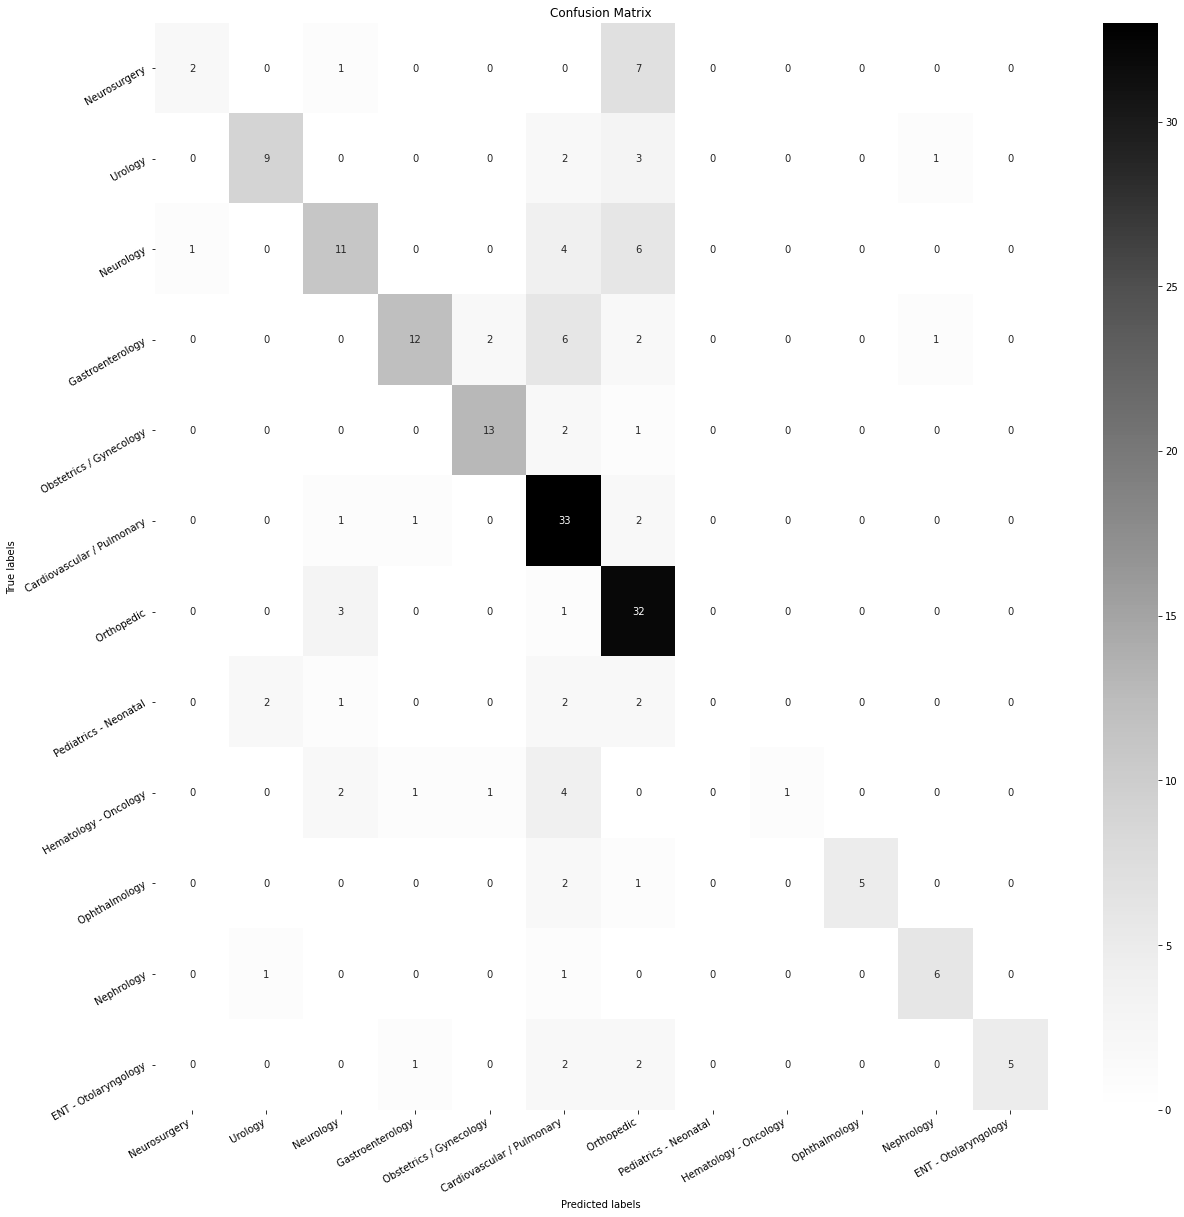

                             precision    recall  f1-score   support

               Neurosurgery       0.67      0.20      0.31        10
                    Urology       0.75      0.60      0.67        15
                  Neurology       0.58      0.50      0.54        22
           Gastroenterology       0.80      0.52      0.63        23
    Obstetrics / Gynecology       0.81      0.81      0.81        16
 Cardiovascular / Pulmonary       0.56      0.89      0.69        37
                 Orthopedic       0.55      0.89      0.68        36
      Pediatrics - Neonatal       0.00      0.00      0.00         7
      Hematology - Oncology       1.00      0.11      0.20         9
              Ophthalmology       1.00      0.62      0.77         8
                 Nephrology       0.75      0.75      0.75         8
       ENT - Otolaryngology       1.00      0.50      0.67        10

                   accuracy                           0.64       201
                  macro avg     

In [ ]:
X_train, X_test, y_train, y_test = tfIdfMat_reduced, tfIdfMat_reduced_test, labels_train, labels_test
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

clf = LogisticRegression().fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Greys",ax = ax,fmt='g');

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

# Approach_2(with different model testing):

1. Using sciscpacy models to detect medical entities in our Medical_Description
2.  scispaCy is a Python package containing spaCy models for processing biomedical, scientific or clinical text

***process_text with scipy* >> clean_text >> lemmatize_text >> TfidfVectorizer >> PCA >> Model traing & testing**

In [ ]:
train_data = med_df_train[['Medical_Description', 'Package']]
train_data = train_data.drop(train_data[train_data['Medical_Description'].isna()].index)

test_data = med_df_test[['Medical_Description', 'Package']]
test_data = test_data.drop(test_data[test_data['Medical_Description'].isna()].index)

#Function pre-process data using scispacy to detect medical entities in transcriptions
def process_Text( text):
    wordlist=[]
    doc = nlp(text)
    for ent in doc.ents:
        wordlist.append(ent.text)
    return ' '.join(wordlist)

def clean_text(text ): 
    text = text.translate(str.maketrans('', '', string.punctuation))
    text1 = ''.join([w for w in text if not w.isdigit()]) 
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    text2 = text1.lower()
    text2 = REPLACE_BY_SPACE_RE.sub('', text2)
    return text2

def lemmatize_text(text):
    wordlist=[]
    lemmatizer = WordNetLemmatizer() 
    sentences=sent_tokenize(text)
    
    intial_sentences= sentences[0:1]
    final_sentences = sentences[len(sentences)-2: len(sentences)-1]
    
    for sentence in intial_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))
    for sentence in final_sentences:
        words=word_tokenize(sentence)
        for word in words:
            wordlist.append(lemmatizer.lemmatize(word))       
    return ' '.join(wordlist)


In [ ]:
train_data['Medical_Description'] = train_data['Medical_Description'].apply(process_Text)
train_data['Medical_Description'] = train_data['Medical_Description'].apply(lemmatize_text)
train_data['Medical_Description'] = train_data['Medical_Description'].apply(clean_text)

test_data['Medical_Description'] = test_data['Medical_Description'].apply(process_Text)
test_data['Medical_Description'] = test_data['Medical_Description'].apply(lemmatize_text)
test_data['Medical_Description'] = test_data['Medical_Description'].apply(clean_text)

In [ ]:
vectorizer = TfidfVectorizer(analyzer='word', stop_words='english',ngram_range=(1,4), max_features=10000)
tfIdfMat  = vectorizer.fit_transform(train_data['Medical_Description'].tolist())

tfIdfMat_test = vectorizer.transform(test_data['Medical_Description'].tolist())

pca = PCA(n_components=0.75)
tfIdfMat_reduced = pca.fit_transform(tfIdfMat.toarray())
labels_train = train_data['Package'].tolist()
category_list = train_data.Package.unique()

tfIdfMat_reduced_test = pca.transform(tfIdfMat_test.toarray())
labels_test = test_data['Package'].tolist()

In [ ]:
#testing different models
X_train, X_test, y_train, y_test = tfIdfMat_reduced, tfIdfMat_reduced_test, labels_train, labels_test
pipelines = []
pipelines.append(('LogisticRegression', Pipeline([('LR',LogisticRegression())])))
pipelines.append(('KNeighborsClassifier', Pipeline([('KNN', KNeighborsClassifier())])))
pipelines.append(('SGDClassifier', Pipeline([('SGD',SGDClassifier())])))
pipelines.append(('svm', Pipeline([('svm',svm.SVC())])))
pipelines.append(('DecisionTreeClassifier', Pipeline([('CART', DecisionTreeClassifier())])))
pipelines.append(('ExtraTreesClassifier', Pipeline([('EXT', ExtraTreesClassifier())])))
pipelines.append(('RandomForestClassifier', Pipeline([('RF', RandomForestClassifier())])))
pipelines.append(('XGBClassifier', Pipeline([('XGB', XGBClassifier())])))
pipelines.append(('LGBMClassifier', Pipeline([('LGBM', LGBMClassifier())])))
pipelines.append(('MLPClassifier', Pipeline([('MLP', MLPClassifier())])))

for name, model in pipelines:
    clf = model.fit(X_train, y_train)
    y_test_pred= clf.predict(X_test)
    print(name)
    print(classification_report(y_test,y_test_pred,labels=category_list))
    print("")

LogisticRegression
                             precision    recall  f1-score   support

               Neurosurgery       0.80      0.40      0.53        10
                    Urology       0.81      0.87      0.84        15
                  Neurology       0.55      0.55      0.55        22
           Gastroenterology       0.86      0.78      0.82        23
    Obstetrics / Gynecology       0.88      0.88      0.88        16
 Cardiovascular / Pulmonary       0.80      0.97      0.88        37
                 Orthopedic       0.71      0.89      0.79        36
      Pediatrics - Neonatal       0.50      0.14      0.22         7
      Hematology - Oncology       1.00      0.22      0.36         9
              Ophthalmology       1.00      1.00      1.00         8
                 Nephrology       0.70      0.88      0.78         8
       ENT - Otolaryngology       1.00      0.90      0.95        10

                   accuracy                           0.78       201
             

Train_Set_Size:(1797, 586)
Test_Set_Size:(201, 586)


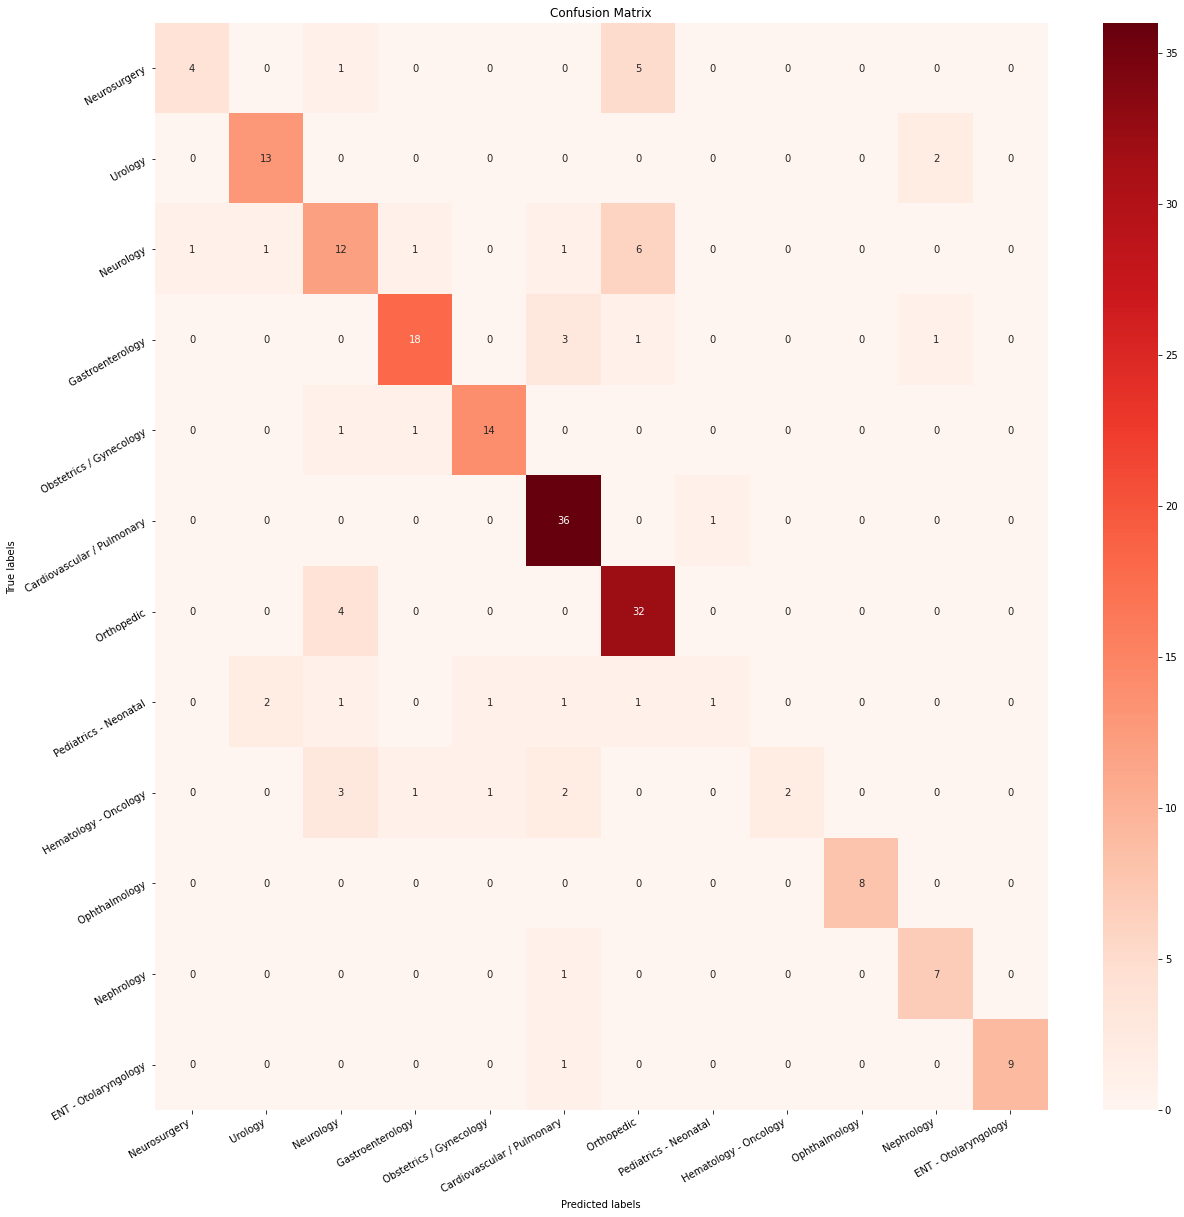

In [ ]:
X_train, X_test, y_train, y_test = tfIdfMat_reduced, tfIdfMat_reduced_test, labels_train, labels_test
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

clf = LogisticRegression().fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Reds",ax = ax,fmt='g'); #annot=True to annotate cells

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()


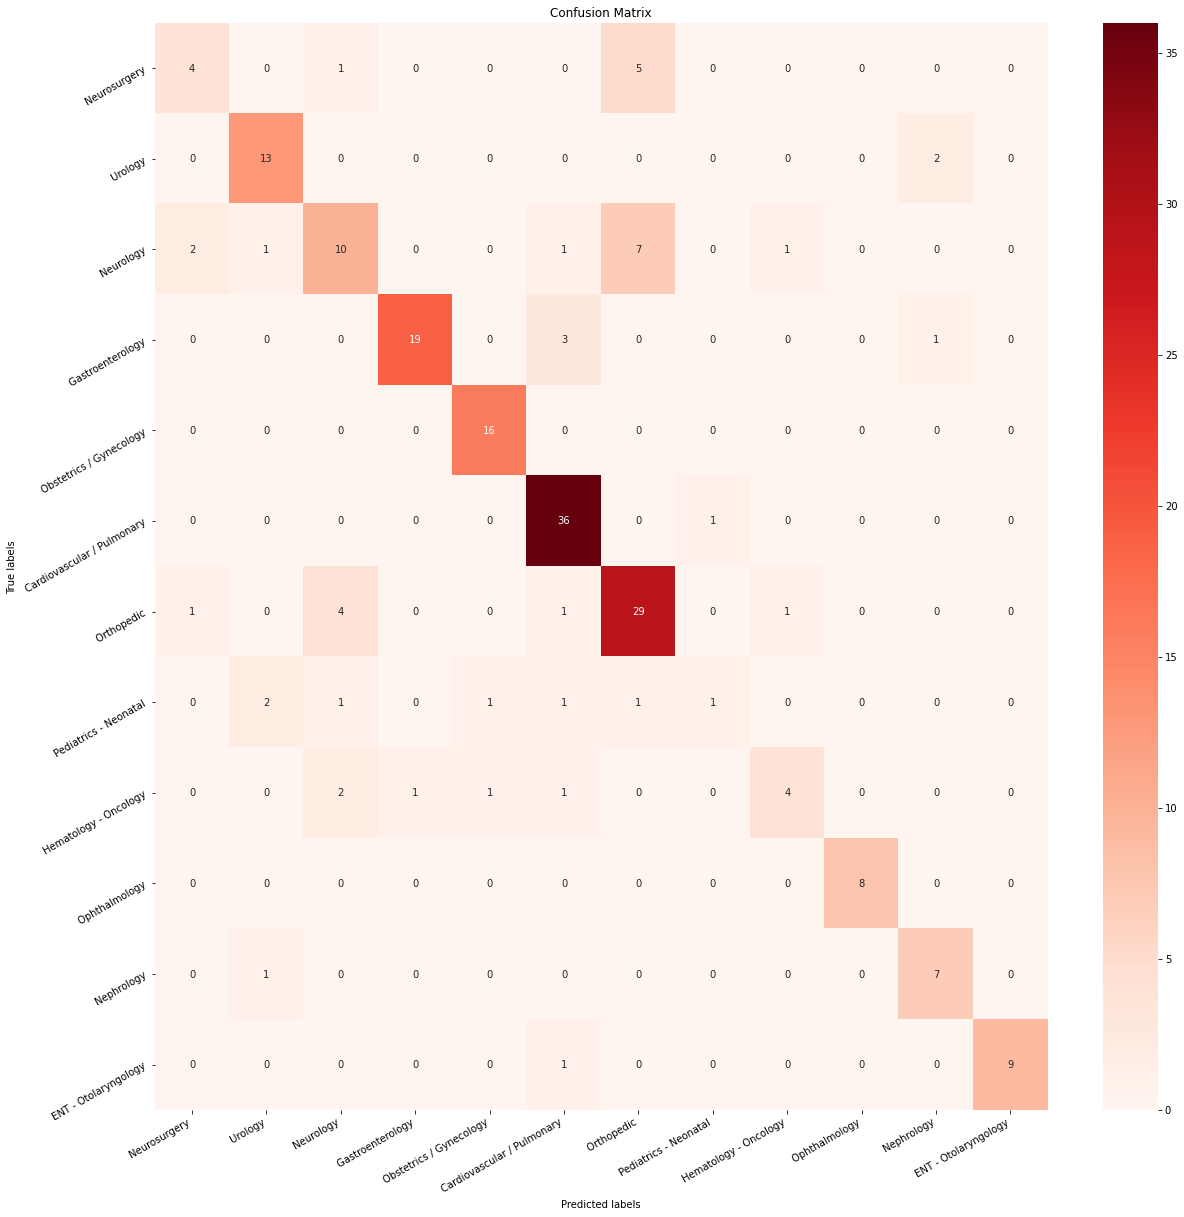

In [ ]:

clf = svm.SVC(random_state=1).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Reds",ax = ax,fmt='g'); #annot=True to annotate cells

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

# Approach_3: 

Since some classes are in minority we can use SMOTE(Synthetic Minority Over-sampling Technique ) to generate more sample form minority class to solve the data imbalance problem

**process_text with scipy >> clean_text >> lemmatize_text >> TfidfVectorizer >> PCA >> *SMOTE* >> Model traing & testing**

Train_Set_Size:(4008, 586)
Test_Set_Size:(201, 586)
                             precision    recall  f1-score   support

               Neurosurgery       0.58      0.70      0.64        10
                    Urology       0.81      0.87      0.84        15
                  Neurology       0.67      0.55      0.60        22
           Gastroenterology       0.91      0.87      0.89        23
    Obstetrics / Gynecology       0.94      1.00      0.97        16
 Cardiovascular / Pulmonary       0.89      0.92      0.91        37
                 Orthopedic       0.76      0.78      0.77        36
      Pediatrics - Neonatal       0.60      0.43      0.50         7
      Hematology - Oncology       0.67      0.44      0.53         9
              Ophthalmology       1.00      1.00      1.00         8
                 Nephrology       0.67      1.00      0.80         8
       ENT - Otolaryngology       0.90      0.90      0.90        10

                   accuracy                      

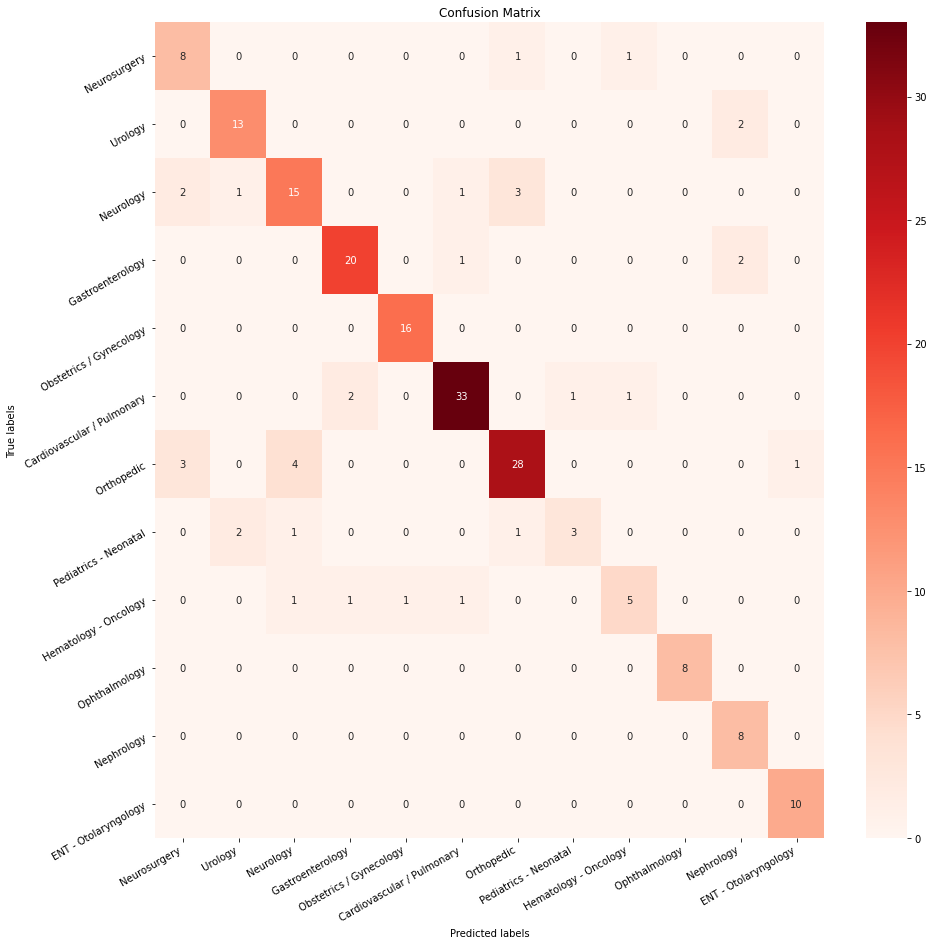

In [ ]:

smote_over_sample = BorderlineSMOTE(k_neighbors=5, kind='borderline-1', m_neighbors=10, n_jobs=1,random_state=1, sampling_strategy='all')
labels_train = train_data['Package'].tolist()
X_train, y_train = smote_over_sample.fit_resample(tfIdfMat_reduced, labels_train)

X_test, y_test = tfIdfMat_reduced_test, labels_test
print('Train_Set_Size:'+str(X_train.shape))
print('Test_Set_Size:'+str(X_test.shape))

clf = LogisticRegression().fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

labels = category_list
print(classification_report(y_test,y_test_pred,labels=category_list))

fig = plt.figure(figsize=(15,15))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Reds",ax = ax,fmt='g'); #annot=True to annotate cells

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

                             precision    recall  f1-score   support

               Neurosurgery       0.58      0.70      0.64        10
                    Urology       0.75      0.80      0.77        15
                  Neurology       0.59      0.45      0.51        22
           Gastroenterology       0.88      0.91      0.89        23
    Obstetrics / Gynecology       0.94      1.00      0.97        16
 Cardiovascular / Pulmonary       0.87      0.89      0.88        37
                 Orthopedic       0.73      0.75      0.74        36
      Pediatrics - Neonatal       0.60      0.43      0.50         7
      Hematology - Oncology       0.50      0.44      0.47         9
              Ophthalmology       1.00      1.00      1.00         8
                 Nephrology       0.67      0.75      0.71         8
       ENT - Otolaryngology       0.90      0.90      0.90        10

                   accuracy                           0.78       201
                  macro avg     

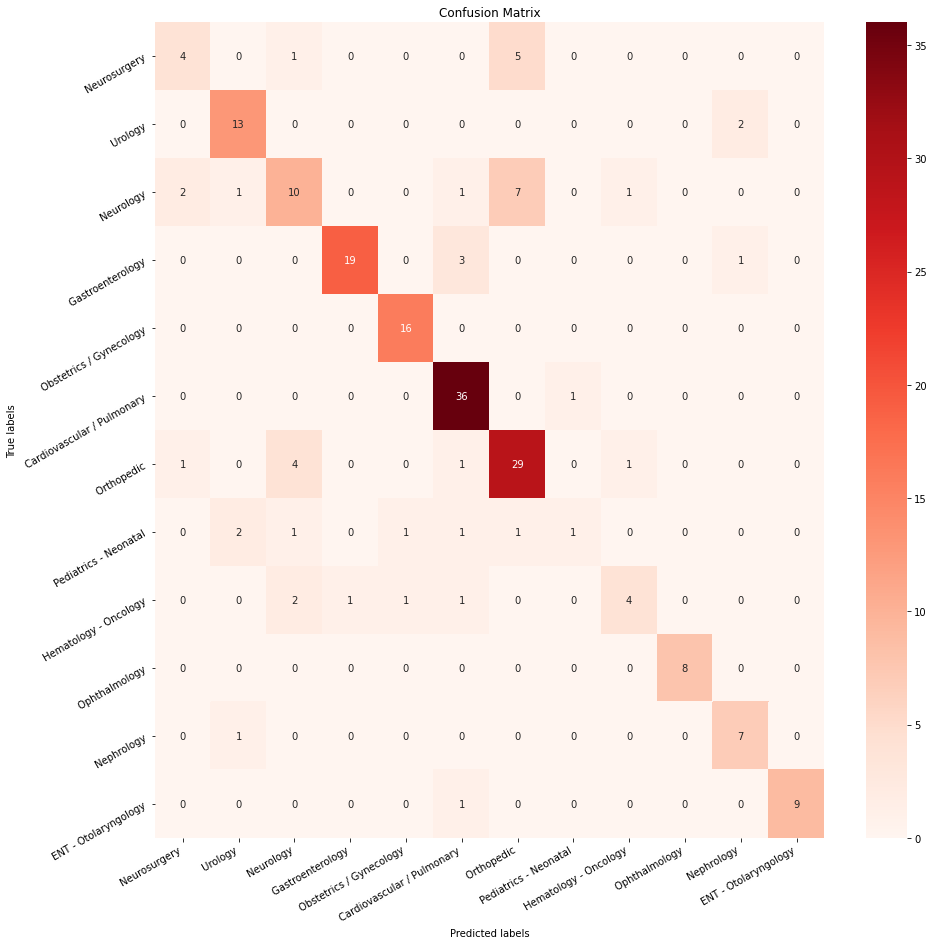

In [ ]:
clf = svm.LinearSVC().fit(X_train, y_train)
y_test_pred= clf.predict(X_test)

labels = category_list
print(classification_report(y_test,y_test_pred,labels=category_list))

fig = plt.figure(figsize=(15,15))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Reds",ax = ax,fmt='g'); #annot=True to annotate cells

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()

LR = 0.81 > LinearSVC() = 0.78

# Approach_4:
Hyperparameter tuning to increase the accuracy

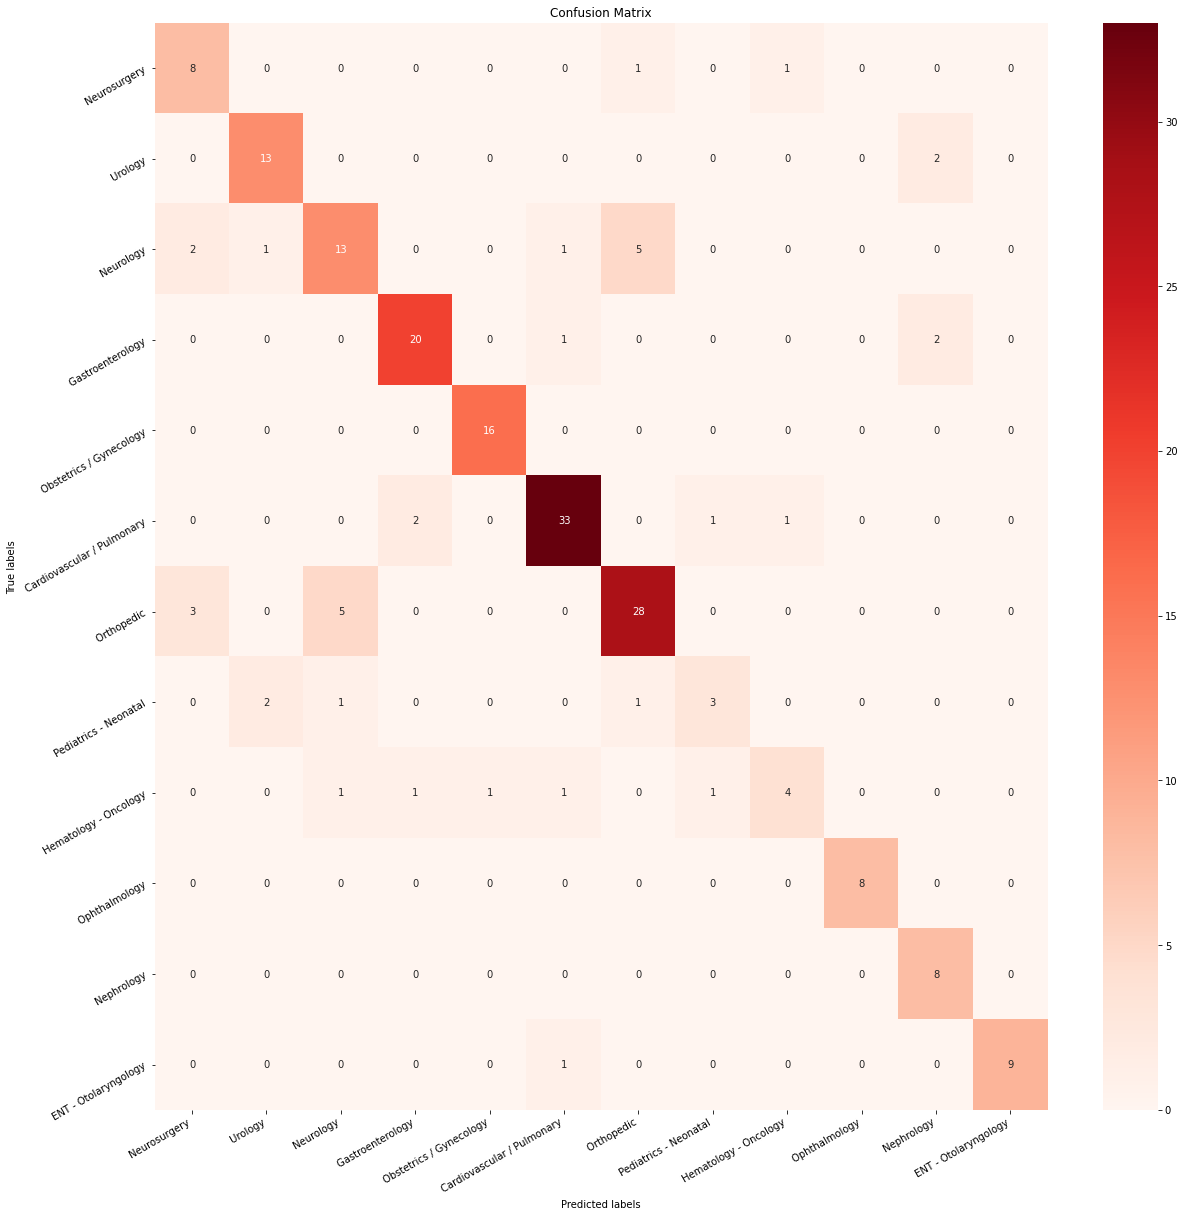

                             precision    recall  f1-score   support

               Neurosurgery       0.62      0.80      0.70        10
                    Urology       0.81      0.87      0.84        15
                  Neurology       0.65      0.59      0.62        22
           Gastroenterology       0.87      0.87      0.87        23
    Obstetrics / Gynecology       0.94      1.00      0.97        16
 Cardiovascular / Pulmonary       0.89      0.89      0.89        37
                 Orthopedic       0.80      0.78      0.79        36
      Pediatrics - Neonatal       0.60      0.43      0.50         7
      Hematology - Oncology       0.67      0.44      0.53         9
              Ophthalmology       1.00      1.00      1.00         8
                 Nephrology       0.67      1.00      0.80         8
       ENT - Otolaryngology       1.00      0.90      0.95        10

                   accuracy                           0.81       201
                  macro avg     

In [ ]:
#penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, max_iter = 1000
clf = MLPClassifier(random_state=1, activation= 'tanh', solver = 'sgd', learning_rate='constant', max_iter=1000).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Reds",ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

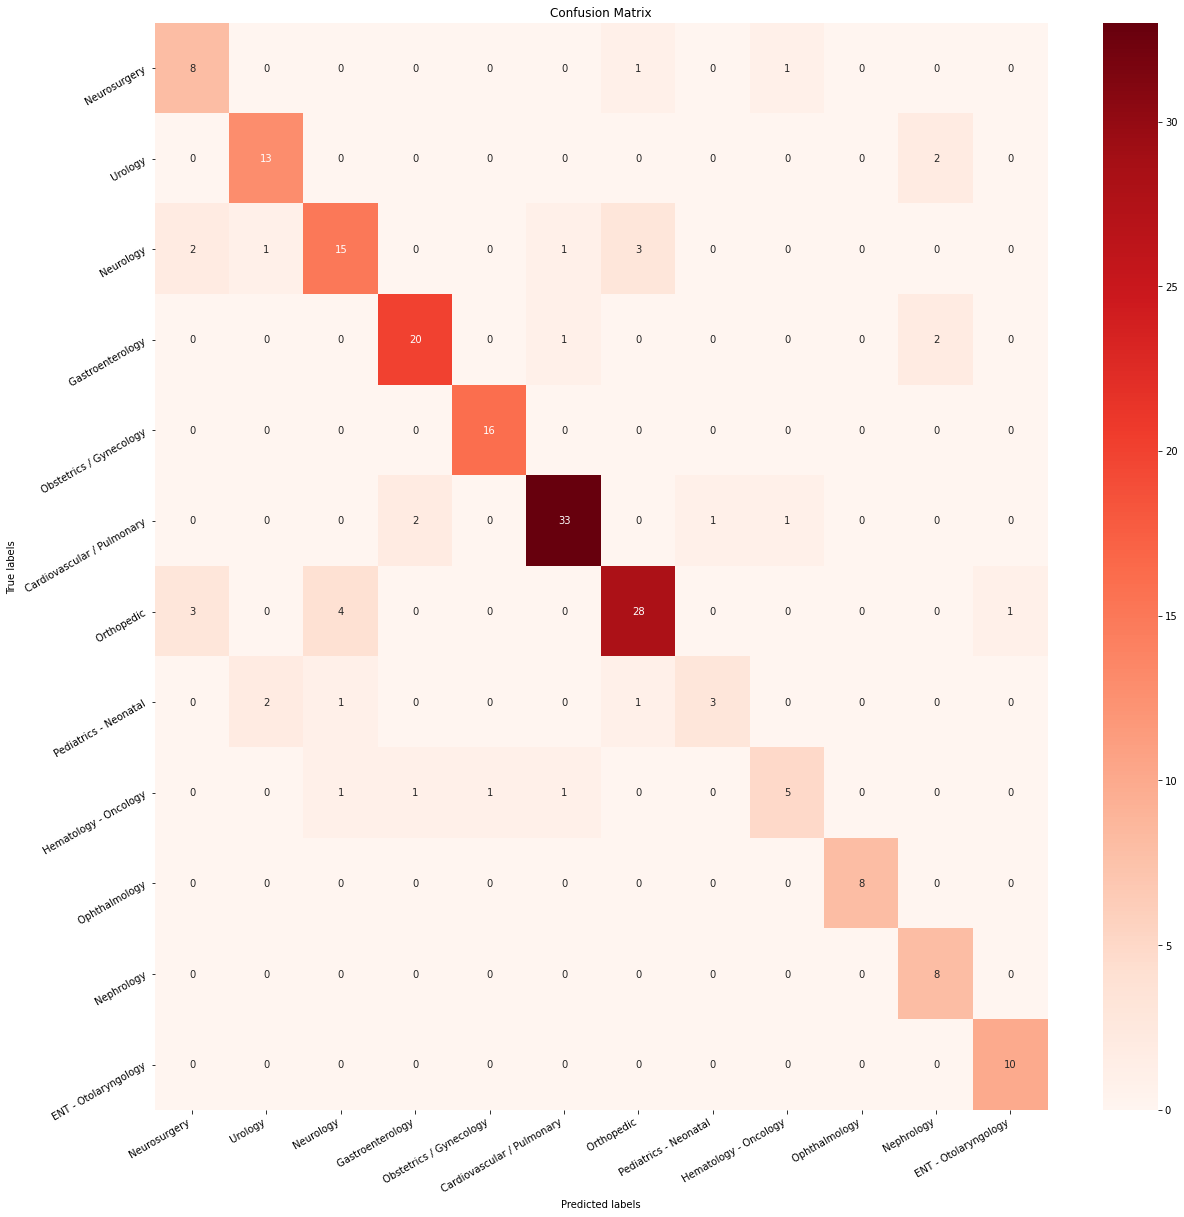

                             precision    recall  f1-score   support

               Neurosurgery       0.62      0.80      0.70        10
                    Urology       0.81      0.87      0.84        15
                  Neurology       0.71      0.68      0.70        22
           Gastroenterology       0.87      0.87      0.87        23
    Obstetrics / Gynecology       0.94      1.00      0.97        16
 Cardiovascular / Pulmonary       0.92      0.89      0.90        37
                 Orthopedic       0.85      0.78      0.81        36
      Pediatrics - Neonatal       0.75      0.43      0.55         7
      Hematology - Oncology       0.71      0.56      0.63         9
              Ophthalmology       1.00      1.00      1.00         8
                 Nephrology       0.67      1.00      0.80         8
       ENT - Otolaryngology       0.91      1.00      0.95        10

                   accuracy                           0.83       201
                  macro avg     

In [ ]:
clf = LogisticRegression(penalty= 'elasticnet', solver= 'saga', l1_ratio=0.5, max_iter = 1000).fit(X_train, y_train)
y_test_pred= clf.predict(X_test)
labels = category_list
cm = confusion_matrix(y_test, y_test_pred, labels)

fig = plt.figure(figsize=(20,20))
ax= fig.add_subplot(1,1,1)
sns.heatmap(cm, annot=True, cmap="Reds",ax = ax,fmt='g'); #annot=True to annotate cells

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')     
plt.show()
print(classification_report(y_test,y_test_pred,labels=category_list))

1. **We have achieved the highest accuracy of 84-83% with Logistic Regression followed by Multilayer perceptron with 82-81% of accuracy**

2. the overall accuracy can be increased by using **BioWordVec** & **BioSentVec** modelstrained on PubMed+MIMIC-III, I'm not able to use these models because of hardware limitation

3. The dataset is **imbalance**

# **Rough_work**

In [ ]:
%%capture
!pip install lime
# Basic libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
import random
import itertools
from collections import defaultdict

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import combinations
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
import lightgbm as lgb

# Evaluation
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [ ]:
def basic_preprocessing(df):
    
    df_temp = df.copy(deep = True)
    
    df_temp = df_temp.rename(index = str, columns = {'Medical_Description': 'text'})
    
    df_temp.loc[:, 'text'] = [text_prepare(x) for x in df_temp['text'].values]
    
    le = LabelEncoder()
    le.fit(df_temp['Package'])
    df_temp.loc[:, 'class_label'] = le.transform(df_temp['Package'])
    
    tokenizer = RegexpTokenizer(r'\w+')

    df_temp["tokens"] = df_temp["text"].apply(tokenizer.tokenize)
    
    return df_temp

def text_prepare(text):

    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub('', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    words = text.split()
    i = 0
    while i < len(words):
        if words[i] in STOPWORDS:
            words.pop(i)
        else:
            i += 1
    text = ' '.join(map(str, words))# delete stopwords from text
    
    return text

# Introduce evaluation metrics

def get_metrics(y_test, y_predicted):  

    precision = precision_score(y_test, y_predicted, average='weighted')             

    recall = recall_score(y_test, y_predicted, average='weighted')
    
    f1 = f1_score(y_test, y_predicted, average='weighted')
    
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

In [ ]:
def BOW(data):
    
    df_temp = data.copy(deep = True)
    df_temp = basic_preprocessing(df_temp)

    count_vectorizer = CountVectorizer()
    count_vectorizer.fit(df_temp['text'])

    list_corpus = df_temp["text"].tolist()
    list_labels = df_temp["class_label"].tolist()
    
    X = count_vectorizer.transform(list_corpus)
    
    return X, list_labels

In [ ]:
def tfidf(data, ngrams = 1):

    
    df_temp = data.copy(deep = True)
    df_temp = basic_preprocessing(df_temp)
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, ngrams))
    tfidf_vectorizer.fit(df_temp['text'])

    list_corpus = df_temp["text"].tolist()
    list_labels = df_temp["class_label"].tolist()

    X = tfidf_vectorizer.transform(list_corpus)
    
    return X, list_labels

In [ ]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [ ]:
def w2v(data):
    
    df_temp = data.copy(deep = True)    
    df_temp = basic_preprocessing(df_temp)
    
    embeddings = get_word2vec_embeddings(word2vec, df_temp)
    list_labels = df_temp["class_label"].tolist()
    
    return embeddings, list_labels

In [ ]:
data = train_data.copy()
data['Medical_Description'] = data['Medical_Description'].apply(process_Text)
clf = LogisticRegression(solver = 'saga', 
                           multi_class = 'multinomial', n_jobs = -1, random_state = 1)

df_res = pd.DataFrame(columns = ['Preprocessing', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

# Bag of words approach
X, y = BOW(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
df_res = df_res.append({'Preprocessing': 'Bag of words',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)

# TF_IDF approach. 1-gram
X, y = tfidf(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
df_res = df_res.append({'Preprocessing': 'TF-IDF 1-gram',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)

# TF_IDF approach. 2-gram
X, y = tfidf(data, ngrams=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
df_res = df_res.append({'Preprocessing': 'TF-IDF 2-gram',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)

# Word2vec
X, y = w2v(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
df_res = df_res.append({'Preprocessing': 'Word2vec',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)

In [ ]:
df_res

,Preprocessing,Precision,Recall,F1-score,Accuracy
0,Bag of words,0.718776,0.706667,0.709976,0.706667
1,TF-IDF 1-gram,0.723927,0.737778,0.714431,0.737778
2,TF-IDF 2-gram,0.640633,0.688889,0.641306,0.688889
3,Word2vec,0.661040,0.702222,0.664703,0.702222


In [ ]:
def training_naive(X_train_naive, X_test_naive, y_train_naive, y_test_naive, preproc):
    
    clf = MultinomialNB()
    clf.fit(X_train_naive, y_train_naive)

    res = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
    
    y_pred = clf.predict(X_test_naive)
    
    f1 = f1_score(y_pred, y_test_naive, average = 'weighted')
    pres = precision_score(y_pred, y_test_naive, average = 'weighted')
    rec = recall_score(y_pred, y_test_naive, average = 'weighted')
    acc = accuracy_score(y_pred, y_test_naive)
    
    res = res.append({'Preprocessing': preproc, 'Model': 'Naive Bayes', 'Precision': pres, 
                     'Recall': rec, 'F1-score': f1, 'Accuracy': acc}, ignore_index = True)

    return res

In [ ]:
def training_logreg(X_train_log, X_test_log, y_train_log, y_test_log, preproc):
    
    
    clf = LogisticRegression(solver = 'saga', multi_class = 'multinomial', n_jobs = -1)
    
    clf.fit(X_train_log, y_train_log)

    res = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
    
    y_pred = clf.predict(X_test_log)
    
    f1 = f1_score(y_pred, y_test_log, average = 'weighted')
    pres = precision_score(y_pred, y_test_log, average = 'weighted')
    rec = recall_score(y_pred, y_test_log, average = 'weighted')
    acc = accuracy_score(y_pred, y_test_log)
    
    res = res.append({'Preprocessing': preproc, 'Model': f'Logistic Regression', 'Precision': pres, 
                     'Recall': rec, 'F1-score': f1, 'Accuracy': acc}, ignore_index = True)

    return res

In [ ]:
def training_lgbm(X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm, preproc,
                 n = 340, depth = 6, child = 9, bag = 0.9, feature = 0.9, l1 = 1, l = 0.01, w2v = False):
    
    if w2v:
        d_train = lgb.Dataset(X_train_lgbm, label=y_train_lgbm)
    else:
        d_train = lgb.Dataset(X_train_lgbm.astype(np.float32), label=y_train_lgbm)

    early_stop = 500
    verbose_eval = False
    num_rounds = n

    params = {
        'objective': 'multiclass',
        'num_class': len(set(y_train_lgbm)),
        'boosting': 'gbdt', 
        'metric': 'multi_logloss',
        'max_depth': depth, 
        'max_bin': 22, 
        'bagging_fraction': bag, 
        'feature_fraction': feature, 
        'min_child_samples': child, 
        'min_child_weight': 1, 
        'learning_rate': l,
        'verbosity': -1, 
        'data_random_seed': 17,
        'lambda_l1': l1}

    model = lgb.train(params, train_set = d_train, num_boost_round = num_rounds)

    y_pred_proba = model.predict(X_test_lgbm.astype(np.float32), num_iteration=model.best_iteration)
    y_pred = [np.argmax(x) for x in y_pred_proba]
    
    res = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
        
    f1 = f1_score(y_pred, y_test_lgbm, average = 'weighted')
    pres = precision_score(y_pred, y_test_lgbm, average = 'weighted')
    rec = recall_score(y_pred, y_test_lgbm, average = 'weighted')
    acc = accuracy_score(y_pred, y_test_lgbm)
    
    res = res.append({'Preprocessing': preproc, 'Model': 'LightGBM', 'Precision': pres, 
                     'Recall': rec, 'F1-score': f1, 'Accuracy': acc}, ignore_index = True)

    return res

In [ ]:
# DataFrame for result evaluation

full_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

# Testing Count Vectorizer
data_100 = data
X, y = BOW(data_100)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
full_result = full_result.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
full_result = full_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

# Testing TF-IDF with 1-gram

X, y = tfidf(data_100, ngrams = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
full_result = full_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
full_result = full_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

# Testing TF-IDF with 2-gram

X, y = tfidf(data_100, ngrams = 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
full_result = full_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)
full_result = full_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)

# Testing Word2vec

X, y = w2v(data_100)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec'), ignore_index = True)

full_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.742777,0.706667,0.716400,0.706667
1,Count Vectorize,Logistic Regression,0.705667,0.706667,0.703232,0.706667
2,Count Vectorize,LightGBM,0.671940,0.657778,0.660488,0.657778
3,TF-IDF 1-grams,Naive Bayes,0.881726,0.648889,0.713865,0.648889
4,TF-IDF 1-grams,Logistic Regression,0.804476,0.737778,0.761124,0.737778
5,TF-IDF 1-grams,LightGBM,0.679639,0.660000,0.664967,0.660000
6,TF-IDF 2-grams,Naive Bayes,0.879654,0.568889,0.651949,0.568889
7,TF-IDF 2-grams,Logistic Regression,0.822563,0.693333,0.740620,0.693333
8,TF-IDF 2-grams,LightGBM,0.670040,0.653333,0.657495,0.653333
9,Word2vec,Logistic Regression,0.803527,0.702222,0.739741,0.702222


In [ ]:
smote_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

smote_over_sample = SMOTE(sampling_strategy='minority')

# Testing Count Vectorizer

X, y = BOW(data_100)
X, y = smote_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)
smote_result = smote_result.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
smote_result = smote_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
smote_result = smote_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

# Testing TF-IDF with 1-gram

X, y = tfidf(data_100, ngrams = 1)
X, y = smote_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1)
smote_result = smote_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
smote_result = smote_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
smote_result = smote_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

# Testing Word2vec

X, y = w2v(data_100)
X, y = smote_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
smote_result = smote_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec'), ignore_index = True)
smote_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.758408,0.725338,0.737696,0.725338
1,Count Vectorize,Logistic Regression,0.739873,0.725338,0.729500,0.725338
2,Count Vectorize,LightGBM,0.706672,0.671180,0.682743,0.671180
3,TF-IDF 1-grams,Naive Bayes,0.815978,0.558994,0.615165,0.558994
4,TF-IDF 1-grams,Logistic Regression,0.798140,0.736944,0.759117,0.736944
5,TF-IDF 1-grams,LightGBM,0.710591,0.682785,0.691449,0.682785
6,Word2vec,Logistic Regression,0.782810,0.678917,0.713238,0.678917
